# Test-04
Ejecutado en **Google Collaboratory**.

# Fuentes

### Link: https://keras.io/api/layers/preprocessing_layers/image_preprocessing/resizing/
Se puede utilizar una capa que realiza una modificación en el tamaño de la imagen, particularmente como se busca aumentar el tamaño de las imágenes del CIFAR-100 a un tamaño aceptado por redes neuronales ya entrenadas como EfficientNet, se debe utilizar interpolación.

### Link: https://stackoverflow.com/questions/50760543/error-oom-when-allocating-tensor-with-shape/50764934
No hay suficiente memoria disponible en la GPU para poder guardar la información de un batch demasiado grande, por eso se usan batch_size pequeños.

### Link: https://stackoverflow.com/questions/47204116/shouldnt-model-trainable-false-freeze-weights-under-the-model
Las capas que no se reentrenan en Transfer Learning se tienen que 'congelar' antes de hacer una compilación del modelo.

# Configuración general

In [1]:
import tensorflow as tf

# Cargando el conjunto de datos

In [2]:
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
x_train_valid = np.load('drive/Shareddrives/Redes Neuronales BIO/CIFAR-100/x_train.npy')
y_train_valid = np.load('drive/Shareddrives/Redes Neuronales BIO/CIFAR-100/y_train.npy')
x_test = np.load('drive/Shareddrives/Redes Neuronales BIO/CIFAR-100/x_test.npy')

# Separando el conjunto de datos

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train_valid, y_train_valid, test_size=0.2, random_state=15, stratify=y_train_valid)

# Visualizando imágenes y transformando tamaño

In [7]:
import matplotlib.pyplot as plt

In [8]:
from tensorflow.keras.layers.experimental.preprocessing import Resizing

In [9]:
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.models import Sequential

In [10]:
# Choose an image
image_index = 6500
image_original = x_train[image_index] / 255

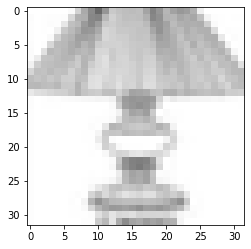

In [11]:
# Show the image
plt.imshow(image_original)
plt.show()

In [12]:
# Create the model
model = Sequential()
model.add(InputLayer(input_shape=(32, 32, 3)))
model.add(Resizing(224, 224, interpolation='bicubic'))

# Compile the model
model.compile()

# Summarize
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 224, 224, 3)       0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Resize the image
image_resized = model.predict(image_original.reshape(-1, 32, 32, 3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


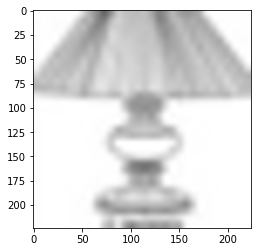

In [14]:
# Show the resized image
plt.imshow(image_resized.reshape(224, 224, 3))
plt.show()

# Data Augmentation con Albumentation

In [15]:
from tensorflow.keras.utils import Sequence

In [16]:
from albumentations import (Compose, ToFloat, HorizontalFlip, VerticalFlip, Rotate,
                            RandomBrightnessContrast, ShiftScaleRotate, RandomSizedCrop,
                            GridDistortion, ElasticTransform)

In [35]:
class AugmentedGenerator(Sequence):
  """ Dataset generator with data augmentation """

  def __init__(self, x, y, batch_size=32, shuffle=True):
    """ Create an instance of the data augmented generator, which is a 
        dataset generator to provide 'on the fly' data augmentation.
        @param x
        @param y
        @param batch_size
        @param shuffle
    """
    # Save internal parameters of the augmented sequence
    self.x = x
    self.y = y
    self.batch_size = batch_size
    self.shuffle = shuffle

    # Initialization
    self.on_epoch_end()
  
  def __len__(self):
    """ Compute the length of an epoch measured in batches
    """
    return int(np.floor(len(self.x) / float(self.batch_size)))
  
  def __getitem__(self, index):
    """ Return the item from the sequence at the given index
        @param index
    """
    # Generate indexes of the batch
    indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]

    # Create data augmented batch
    batch_x = np.empty((self.batch_size, 32, 32, 3))
    batch_y = np.empty((self.batch_size, 1))

    for i, index in enumerate(indexes):
      # Fetch and transform the image
      image_original = self.x[index]
      image_augmented = self.__transform(image_original)
      # Save image and expected output in batch
      batch_x[i,:,:,:] = image_augmented
      batch_y[i,:] = self.y[index]

    # Return an augmented version of the batch
    return batch_x, batch_y
  
  def __transform(self, image):
    """ Transforms an image applying random processes from Albumentation
        @param image
    """
    transform = Compose([ShiftScaleRotate(shift_limit=0.1,
                                            scale_limit=0.2,
                                            rotate_limit=30,
                                            p=0.5),
                         HorizontalFlip(p=0.5),
                         VerticalFlip(p=0.5),
                         GridDistortion(p=0.2),
                         ElasticTransform(p=0.2),
                         RandomBrightnessContrast(p=0.5)
                         ])
    return transform(image=image)['image']

  def on_epoch_end(self):
    """ Updates indexes after each epoch
    """
    self.indexes = np.arange(len(self.x))
    if self.shuffle is True:
        np.random.shuffle(self.indexes)

In [36]:
generator = AugmentedGenerator(x_train, y_train)

# Modelo

In [19]:
from tensorflow.keras.applications import EfficientNetB0

In [20]:
from tensorflow.keras.layers import (GlobalAveragePooling2D, Dense, Activation, 
                                     BatchNormalization, Reshape)

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [22]:
from tensorflow.keras.optimizers import Adam

In [23]:
from tensorflow import keras

In [24]:
# Create the model
model = Sequential()
model.add(InputLayer(input_shape=(32, 32, 3)))
model.add(Resizing(224, 224, interpolation='bicubic'))
model.add(EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3)))
model.add(GlobalAveragePooling2D())
model.add(Dense(units=100))
model.add(BatchNormalization())
model.add(Activation('softmax'))

# Freeze the EfficientNetB0
model.layers[1].trainable = False

# Compile the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy']
             )

# Summarize
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_1 (Resizing)        (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               128100    
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_________________________________________________________________
activation (Activation)      (None, 100)               0         
Total params: 4,178,071
Trainable params: 128,300
Non-trainable params: 4,049,771
______________________________________

In [37]:
# Create the ModelCheckpoint callback to save the best model during training
mc_callback = ModelCheckpoint('model_1.hdf5',
                              monitor='val_accuracy',
                              save_best_only=True,
                              verbose=0,
                              mode='max'
                             )

# Create the EarlyStopping callback to stop when not improving during training
es_callback = EarlyStopping(monitor='val_accuracy', mode='min', verbose=1, patience=5)

# Train the model
epochs = 10
model.fit(generator,
          validation_data=(x_valid, y_valid), 
          callbacks=[mc_callback, es_callback],
          epochs=epochs)

Epoch 1/10
1250/1250 [==============================] - 201s 161ms/step - loss: 2.6820 - accuracy: 0.3831 - val_loss: 1.1677 - val_accuracy: 0.6875


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
1250/1250 [==============================] - 201s 161ms/step - loss: 2.6216 - accuracy: 0.3861 - val_loss: 1.1671 - val_accuracy: 0.6846
Epoch 3/10
1250/1250 [==============================] - 205s 164ms/step - loss: 2.5840 - accuracy: 0.3946 - val_loss: 1.1661 - val_accuracy: 0.6854
Epoch 4/10
1250/1250 [==============================] - 201s 160ms/step - loss: 2.5648 - accuracy: 0.3966 - val_loss: 1.1580 - val_accuracy: 0.6870
Epoch 5/10
1250/1250 [==============================] - 200s 160ms/step - loss: 2.5309 - accuracy: 0.4033 - val_loss: 1.1568 - val_accuracy: 0.6865
Epoch 6/10
1250/1250 [==============================] - 200s 160ms/step - loss: 2.5129 - accuracy: 0.4078 - val_loss: 1.1584 - val_accuracy: 0.6881
Epoch 7/10
1250/1250 [==============================] - 204s 163ms/step - loss: 2.4795 - accuracy: 0.4151 - val_loss: 1.1518 - val_accuracy: 0.6909
Epoch 8/10
1250/1250 [==============================] - 200s 160ms/step - loss: 2.4702 - accuracy: 0.4138 - val_

In [28]:
# Load the model and show the final metrics
model = keras.models.load_model('model_1.hdf5')

# Train and validation metrics
_, train_acc = model.evaluate(x_train, y_train, verbose=0)
_, valid_acc = model.evaluate(x_valid, y_valid, verbose=0)

# Show result
print(f'[Accuracy] Train: {round(train_acc, 3)} Valid: {round(valid_acc, 3)}')

[Accuracy] Train: 0.763 Valid: 0.698
